# Part 1 - Machine Learning

## Importing necessary modules

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Preparing the data

## Import data as a pandas dataframe and shuffling it

In [4]:
data = pd.read_csv("data.csv")
data = data.sample(frac=1)

## Preparing data
1. Data is split into inputs(X) and targets(y) and converted into numpy arrays.
2. Inputs are normalised
3. Data is split into training set and testing set.

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Splitting data into inputs and targets
y = data[['Y1','Y2']]
X =  data[['X1','X2','X3','X4','X5','X6','X7','X8']]
y = np.array(y)
X = np.array(X)

# Normalising inputs
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

PCA was not used on this dataset for the following reasons:
1. There is no intention to plot the data, thus removing the need to reduce the dimensions to something we can understand.
2. Dataset is small and easy to compute, thus again not requiring PCA to reduce computational complexity.
3. When PCA was used the models performed very poorly, the MSE was more than double the current values for all models. 

## Regression function
Function that takes a model, training and testing data, trains the model and uses it to predict training and testing values and returns both the values in an array.

In [6]:
from sklearn.metrics import mean_squared_error

def regressor(model,x_train,y_train,x_test,y_test):
    model.fit(x_train,y_train)
    testoutputs = model.predict(x_test)
    trainoutputs = model.predict(x_train)
    return [mean_squared_error(testoutputs,y_test),mean_squared_error(trainoutputs,y_train)]

# Regression models

This section shows the initialisation of the 3 models and demonstrates each model being able to provide a prediction for a given input (the testing data in this case)

## 1. Neural Network Regressor

In [7]:
from sklearn.neural_network import MLPRegressor

MLP = MLPRegressor(max_iter=5000)
result = regressor(MLP,X_train,y_train,X_test,y_test)
print("Neural Network MSE with testing data: ",result[0])
print("Neural Network MSE with training value: ",result[1])

Neural Network MSE with testing data:  8.646068865990683
Neural Network MSE with training value:  8.263864171010525


## 2. Random Forest Regressor

In [8]:
from sklearn.ensemble import RandomForestRegressor

RFR = RandomForestRegressor()
result = regressor(RFR,X_train,y_train,X_test,y_test)
print("Random Forest MSE with testing data: ",result[0])
print("Random Forest MSE with training value: ",result[1])

Random Forest MSE with testing data:  1.6358794483116867
Random Forest MSE with training value:  0.28578782716612394


## 3. Support Vector Machine Regressor

In [9]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

SVR = MultiOutputRegressor(SVR())

result = regressor(SVR,X_train,y_train,X_test,y_test)
print("Support Vector Machine MSE with testing data: ",result[0])
print("Support Vector Machine MSE with training value: ",result[1])

Support Vector Machine MSE with testing data:  9.680024718374083
Support Vector Machine MSE with training value:  8.430533130552513


## KFold Cross Validation

In [10]:
from sklearn.model_selection import KFold

# Creating a Kfold object which will shuffle the data and then split the data into 5 equal parts.
kf5 = KFold(n_splits=5 , random_state = 4, shuffle=True)

# Initialising empty arrays to store MSE values from each fold
RFRvalues = MLPvalues = SVMvalues = np.empty((0,2))

# For loop iterating over the 5 different folds and appending the resulting MSE from each fold for each model to the arrays above.
for train_index, test_index in kf5.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index],y[train_index], y[test_index]

    MLPvalues = np.append(MLPvalues, [regressor(MLP,X_train,y_train,X_test,y_test)], axis = 0)
    RFRvalues = np.append(RFRvalues, [regressor(RFR,X_train,y_train,X_test,y_test)], axis = 0)
    SVMvalues = np.append(SVMvalues, [regressor(SVR,X_train,y_train,X_test,y_test)], axis = 0)

# Visualisation
Data is visualised using a Boxplot showing the MSE values of each model when each of them are tested by predicting the testing data and the training data.

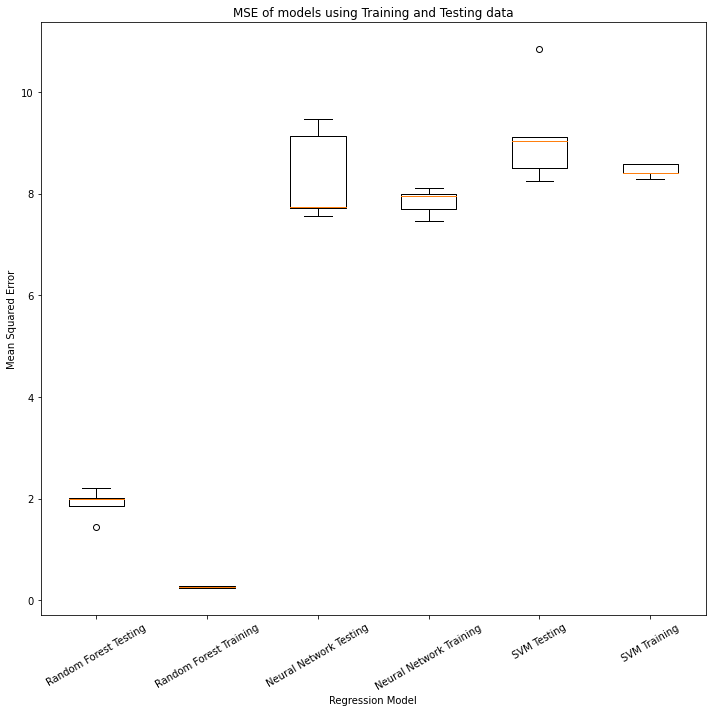

In [12]:
# Dictionary which stores the arrays and their respective names, making it easier for the developer to test and edit.
data = {'Random Forest Testing': RFRvalues[:,0],'Random Forest Training': RFRvalues[:,1], 'Neural Network Testing': MLPvalues[:,0], 'Neural Network Training': MLPvalues[:,1], 'SVM Testing':SVMvalues[:,0], 'SVM Training':SVMvalues[:,1]}

fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
plt.title("MSE of models using Training and Testing data")

ax.boxplot(data.values())
ax.set_xticklabels(data.keys(),rotation=30)
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Regression Model')

plt.show()

# Part 2 - Optimisation

## Data Structure Creation

The data structure used here is a 2 dimensional numpy array with a shape of 20x3. Each row will be one of the 20 sessions. The first column of the 20x3 array is taken to be a lecture theatre and the other two columns are the labs. This is constrained by a precedence constraint condition in the fitness function.

Each element in the array will be a Module object defined below which has attributes taken from the given txt file. 

#### Creating the Module Class 

In [121]:
# Creating the Module class
class Module():
    def __init__(self,module):
        module = module.split('|')
        self.name = module[0]
        self.staff = module[1]
        self.labs = module[2]
        self.constraints = module[3].split(',')

#### Importing the modules and making an array of all modules

In [122]:
# Opening the file and importing the data into a modules array.
f = open('Modules.txt','r')
modules = []
line = f.readline()
while line:
    modules.append(Module(line))
    line = f.readline()
f.close()

# Duplicating module objects corresponding to the number of labs each module has and adding it to a new list.
modulesWithLabs = modules   
for i in modules:
    modulesWithLabs = modulesWithLabs + ([i]*int(i.labs))

#### Converting the array of modules into a usable timetable data structure and generating a random timetable

In [123]:
# Creating an empty 1 dimensional array with 60 empty module objects
timetable = np.full((60,),Module("Empty|None|None|None,None"),dtype=Module)

# Populating the empty array with module objects.
k = 0
for i in range(len(timetable)):
    timetable[i] = modulesWithLabs[k]
    k = k+1
    if k>=len(modulesWithLabs):
        break
            
# Shuffling the array so a random array of 60 module objects is made.
np.random.shuffle(timetable)

# The module is reshaped to 20x3.
timetable = np.reshape(timetable,(20,3))

#### Displaying the timetable

In [124]:
# Displaying the random timetable
print(["Lecture","Lab 1","Lab 2"])
for i in timetable:
    print([i[0].name,i[1].name,i[2].name])

['Lecture', 'Lab 1', 'Lab 2']
['Empty', 'MOD010', 'MOD015']
['MOD008', 'MOD002', 'MOD013']
['MOD011', 'MOD006', 'MOD013']
['Empty', 'MOD007', 'MOD016']
['MOD002', 'MOD015', 'MOD014']
['MOD009', 'MOD011', 'MOD014']
['MOD005', 'Empty', 'Empty']
['MOD006', 'MOD004', 'MOD015']
['MOD007', 'Empty', 'MOD012']
['MOD006', 'MOD003', 'MOD001']
['MOD001', 'Empty', 'MOD008']
['MOD002', 'MOD009', 'MOD012']
['MOD017', 'MOD010', 'MOD012']
['MOD005', 'Empty', 'Empty']
['Empty', 'MOD003', 'MOD016']
['MOD001', 'MOD017', 'MOD003']
['MOD009', 'MOD005', 'MOD006']
['Empty', 'MOD014', 'MOD009']
['MOD011', 'Empty', 'Empty']
['MOD008', 'MOD004', 'MOD010']


#### Function that generates a random timetable
Uses the same logic shown above

In [126]:
def generate_random_timetable(modules):
    timetable = np.full((60,),Module("Empty|None|None|None,None"),dtype=Module)
    k = 0
    for i in range(len(timetable)):
        timetable[i] = modulesWithLabs[k]
        k = k+1
        if k>=len(modulesWithLabs):
            break
    np.random.shuffle(timetable)
    timetable = np.reshape(timetable,(20,3))
    return timetable

#### Function to print out a timetable

In [127]:
def printTimetable(timetable):
    print(["Lecture","Lab 1","Lab 2"])
    for i in timetable:
        print([i[0].name,i[1].name,i[2].name])

## Creation of fitness function

#### Concurrence function
Function that takes in a session and returns the concurrence constraint of that session by checking each module against the constraints of the other modules and against itself to reduce duplicates of the same module in one session.

In [128]:
def checkConcurrence(li):
    count = 0
    #Checks if module is against another module that clashes.
    if li[0].name in li[1].constraints or li[0].name in li[2].constraints:
        count = count + 1
    if li[1].name in li[2].constraints or li[1].name in li[0].constraints:
        count = count + 1
    if li[2].name in li[0].constraints or li[2].name in li[1].constraints:
        count = count + 1
    
    #Checks if one module is being held at the same time in different rooms.
    if li[0].name==li[1].name:
        count = count + 1
    if li[1].name==li[2].name:
        count = count + 1
    if li[2].name==li[0].name:
        count = count + 1
    
    return count

#### Precedence Function
Function that returns the precedence constraint of a whole timetable by looping through the lecture theatres and checking if there are any labs in the previous sessions with the same name as the current lecture in the lecture theatre. This function also ensures the labs are in the labs columns and the lectures are in the lecture theatre columns.

In [129]:
def checkPrecedence(li):
    count = 0
    for i in range(len(li)):
        lecture = li[i][0].name
        if lecture == 'Empty':
            continue
        for j in range(0,i):
            #Checks if the lecture for this week has already been held before.
            if lecture == li[j][0].name:
                count = count + 1
            #Checks if the lecture is being held after the lab session of a lecture.
            if lecture == li[j][1].name:
                count = count + 1
            if lecture == li[j][2].name:
                count = count + 1
    return count

#### Fitness function
Function that utilises the previous two functions. It calculates the precedence and concurrence constraints, adds 1 to each value (to counteract the zero property of multiplication) and then multiplies it to return a final fitness value.

In [131]:
def fitness(timetable):
    precedence = checkPrecedence(timetable) + 1
  
    concurrence = 1
    for i in timetable:
        concurrence = concurrence + checkConcurrence(i)
    return precedence * concurrence

## Functions for the hillclimber

#### Comparison Function
Returns the timetable with the lower fitness

In [132]:
def compare_fitness(child,parent):
    return child<=parent

#### Ruin and recreate mutator function
Generates a completely new timetable each time.

In [133]:
def ruin_and_recreate(timetable):
    timetable = generate_random_timetable(modules)
    return timetable

#### Session Replace mutator function
Swaps two randomly selected modules in a timetable

In [134]:
def session_replace(timetable):
    row = np.random.randint(0,20,2)
    col = np.random.randint(0,3,2)
    timetable[row[0]][col[0]], timetable[row[1]][col[1]] = timetable[row[1]][col[1]], timetable[row[0]][col[0]]
    return timetable
timetable = session_replace(timetable)

## Hillclimber Function
All the best fitnesses are stored in the fitness_list array and returned at the end of the function.

In [135]:
def hillclimber(Niter, problem, data, generate, mutation, comparison):
    parent = generate(data)
    parent_fitness = problem(parent)
    fitness_list = [parent_fitness]
    
    for i in range(Niter):
        #Mutate
        child = mutation(parent)
        
        #Evaluate
        child_fitness = problem(child)
        
        #Pick next parent solution
        if comparison(child_fitness,parent_fitness):
            parent = child
            parent_fitness = child_fitness
            fitness_list.append(child_fitness)
        else:
            fitness_list.append(parent_fitness)
            
    return parent, fitness_list

## Evaluation

#### Running the hillclimber
The hillclimber is run 30 times with 500 iterations each for each mutator and their fitness lists are stored in their own arrays.

In [136]:
ruin_and_recreate_fitnesses = []
session_replace_fitnesses = []
for i in range(30):
    optimised_timetable, fitnesslist = hillclimber(500,fitness,modulesWithLabs,generate_random_timetable,ruin_and_recreate,compare_fitness)
    ruin_and_recreate_fitnesses.append(fitnesslist)
    
    optimised_timetable, fitnesslist = hillclimber(500,fitness,modulesWithLabs,generate_random_timetable,session_replace,compare_fitness)
    session_replace_fitnesses.append(fitnesslist)

## Visualisation

#### Plotting min, max and average of fitnesses for each mutator.

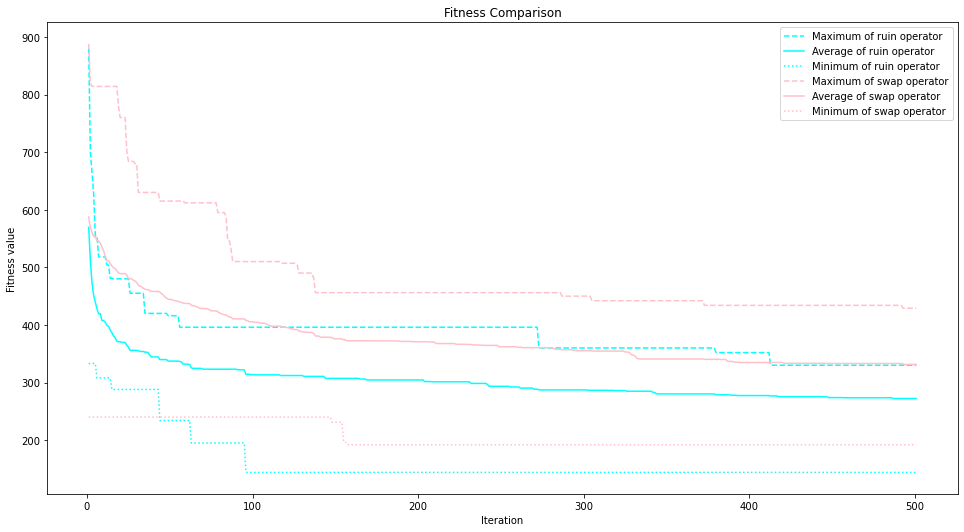

In [137]:
# X-Axis values
X = [i for i in range(1,502)]

# Plotting the lines for the ruin operator, using numpy for easy iterations.
ruin = np.array(ruin_and_recreate_fitnesses)
ruinmaxlist = [max(ruin[:,i]) for i in range(501)]
ruinavglist = [sum(ruin[:,i])/len(ruin[:,i]) for i in range(501)]
ruinminlist = [min(ruin[:,i]) for i in range(501)]

plt.plot(X,ruinmaxlist,color='cyan',linestyle='dashed',label="Maximum of ruin operator")
plt.plot(X,ruinavglist,color='cyan',linestyle="solid",label="Average of ruin operator")
plt.plot(X,ruinminlist,color='cyan',linestyle="dotted",label="Minimum of ruin operator")

# Plotting the lines for the swap operator, using numpy for easy iterations.
swap = np.array(session_replace_fitnesses)
swapmaxlist = [max(swap[:,i]) for i in range(501)]
swapavglist = [sum(swap[:,i])/len(ruin[:,i]) for i in range(501)]
swapminlist = [min(swap[:,i]) for i in range(501)]

plt.plot(X,swapmaxlist,color='pink',linestyle="dashed",label="Maximum of swap operator")
plt.plot(X,swapavglist,color='pink',linestyle="solid",label="Average of swap operator")
plt.plot(X,swapminlist,color='pink',linestyle="dotted",label="Minimum of swap operator")

    
plt.rcParams["figure.figsize"] = [13.50, 7.50]
plt.rcParams["figure.autolayout"] = True
plt.legend(loc="upper right")
plt.xlabel('Iteration')
plt.ylabel('Fitness value')
plt.title("Fitness Comparison")
plt.show()
print()

## Conclusion

From the graph above we can see that the ruin and recreate operator consistently shows lower maximum, average and minimum fitnesses than the swap operator. Thus we can safely assume that the ruin and recreate operator is the better mutation operator to use.